In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import itertools

from multiprocessing import Pool

In [2]:
%run config.py
%run shared.py

In [3]:
valid = pd.read_pickle(PATH_VALID_DEVICES)

# Notifications per hour

**RQ:** How many notifications are in the notification drawer per hour?

In [4]:
def worker_active_notifications_per_hour(uuid):
    df = pd.read_pickle('%s%s.pkl.gz' % (PATH_DEVICES_DIR, uuid), compression='gzip')
    result = pd.DataFrame(columns=[h for h in range(0, 24)])
    d = {}
    for h in result.columns:
        d[h] = df[df.LocalTime.dt.hour == h].Active.apply(filter_active).apply(len).mean()
    return result.append(d, ignore_index=True)

In [5]:
uuids = valid.UUID.tolist()

p = Pool(NUM_CORES)
lst = p.map(worker_active_notifications_per_hour, uuids)

active = pd.concat(lst)
active = active.reset_index(drop=True)
active.tail()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
3948,0.688525,1.078431,1.175000,1.421053,1.451613,1.656250,0.937500,0.407407,0.434783,0.628205,...,0.558442,0.597701,0.402597,0.640000,0.761364,0.810127,0.714286,0.458824,0.550000,0.693333
3949,1.121212,0.916667,0.882353,0.850000,0.970588,1.048780,0.756757,0.395349,0.309524,0.371429,...,0.750000,1.189189,1.027778,1.281250,1.238095,1.387755,1.431818,1.666667,0.977778,0.714286
3950,15.569536,15.267516,14.766234,14.610390,15.074324,15.134228,15.609589,16.130137,16.572368,17.267123,...,17.490566,16.339286,16.790419,17.383721,17.375758,17.660819,18.382716,17.987261,18.071429,17.265306
3951,1.937500,1.864198,1.824324,1.986301,1.506849,1.763889,2.480000,2.873239,2.647887,1.803030,...,2.324324,1.904110,1.937500,1.891566,2.333333,2.729730,2.197368,2.243902,1.887500,1.767442
3952,0.727273,0.708333,0.673913,0.595745,0.612903,0.620690,0.741935,0.852941,0.896552,0.774194,...,0.636364,0.340000,0.604167,0.560000,0.622222,0.590909,0.545455,0.562500,0.642857,0.488372


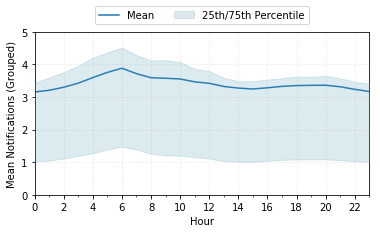

In [6]:
ax = active.fillna(0).mean(axis=0).plot(
    kind='line',
    xlim=(0, 23),
    xticks=range(0, 24, 1),
    yticks=range(0, 7, 1),
    ylim=(0, 5),
    figsize=(6, 3),
    legend=True,
    grid=True)

# Ticks
ax.set_xticks(range(0, 24, 2))
ax.set_xticks(range(0, 24, 1), minor=True)
ax.set_yticks(range(0, 6, 1))

# Grid
ax.set_axisbelow(True)
ax.xaxis.grid(alpha=0.2, linestyle='dashed')
ax.yaxis.grid(alpha=0.2, linestyle='dashed')

# Tweak font sizes
ax.set_xlabel('Hour', fontsize=10)
ax.set_ylabel('Mean Notifications (Grouped)', fontsize=10)
ax.tick_params(labelsize=10)

# Quantiles
ax.fill_between(range(0, 24),
                [active.fillna(0)[x].quantile(.25) for x in active.fillna(0).columns],
                [active.fillna(0)[x].quantile(.75) for x in active.fillna(0).columns],
                color='#539caf',
                alpha=0.2,
                zorder=100) # hatch='/'

# Std
# ax.fill_between(range(0, 24),
#                 [active.fillna(0)[x].mean() - active.fillna(0)[x].std() for x in active.fillna(0).columns],
#                 [active.fillna(0)[x].mean() + active.fillna(0)[x].std() for x in active.fillna(0).columns],
#                 color='#539caf',
#                 alpha=0.2)

# Overall mean
#ax.axhline(active.mean().mean(), color='r', linestyle='--')

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles+[patches.Patch(color='#539caf', alpha=0.2)], # hatch='///',
          labels=['Mean', '25th/75th Percentile'],
          loc='center',
          bbox_to_anchor=(0.5, 1.1),
          ncol=3, 
          prop={'size': 10})

plt.savefig('figures/mean_notifications_per_hour.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.savefig('figures/mean_notifications_per_hour.pdf', bbox_inches='tight', pad_inches=0)

plt.show()